In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import random


import numpy as np

For reproducibility and consistency across runs, we will set a seed

In [2]:
def set_random_seeds(seed=1):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        
set_random_seeds()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(torch.cuda.get_device_name(0))  # Prints the GPU name

Using device: cuda
NVIDIA GeForce GTX 1650 Ti


Loading the MNIST dataset. Changing the __getitem_ function to give a touple label with the number and a unique idx

In [3]:
# Custom MNIST dataset that returns image and a tuple (index, label)
class IndexedMNIST(datasets.MNIST):
    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        # Return image and a tuple (unique index, label)
        return image, (index, label)
        
def load_mnist_data(batch_size=256, download=True):
    """
    Loads and returns MNIST train and test DataLoaders with flattened images.
    Each sample's label is a tuple containing a unique index and the actual label.
    
    Args:
        batch_size (int): The batch size for the DataLoader.
        download (bool): Whether to download the dataset if not found.
    
    Returns:
        train_loader, test_loader: DataLoader objects for the MNIST dataset.
    """
    # Define a transform to normalize and flatten the data
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Lambda(lambda x: x.view(-1))  # flatten image to a 1D vector of size 784
    ])
    
    # Load the training and test datasets
    train_dataset = IndexedMNIST(root='../datasets', train=True, transform=transform, download=download)
    test_dataset = IndexedMNIST(root='../datasets', train=False, transform=transform, download=download)
    
    # Create DataLoaders for the datasets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

AutoEncoder Class

In [ ]:
class Autoencoder(nn.Module):
    """
    Autoencoder with a bottleneck of size 2 that maps MNIST images to a 2D latent space.
    Includes training, evaluation, and embedding extraction methods.
    """

    def __init__(self, latent_dim=2, hidden_size=128):
        super().__init__()
        # Encoder layers
        # 784 -> 128 -> 2
        encoder_layers = [
            nn.Linear(28 * 28, hidden_size), # asuming size 28x28 of the images
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, latent_dim), # the size 2 bottleneck layer
            nn.BatchNorm1d(latent_dim)
        ]
        self.encoder = nn.Sequential(*encoder_layers) # '*' is unpacking the list into it's elements

        # Decoder layers
        # 2 -> 128 -> 784
        decoder_layers = [
            nn.Linear(latent_dim, hidden_size),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, 28 * 28),
            nn.Sigmoid() # normalize outputs to [0, 1] - grayscale
        ]
        self.decoder = nn.Sequential(*decoder_layers)

    def encode(self, x):
        """
        Encodes an input batch (e.g., MNIST images) into the latent space.
        
        Args:
            x (Tensor): Input images of shape [batch_size, 784].
        Returns:
            z (Tensor): Encoded latent vectors of shape [batch_size, latent_dim].
        """

        z = self.encoder(x)
        return z


    def decode(self, z):
        """
        Decodes latent vectors back to the original image space.
        
        Args:
            z (Tensor): Latent vectors of shape [batch_size, latent_dim].
        Returns:
            x_rec (Tensor): Reconstructed images of shape [batch_size, 784].
        """

        x_rec = self.decoder(z)
        return x_rec

    def forward(self, x):
        """
        Complete forward pass: encode then decode.
        
        Args:
            x (Tensor): Input images.
        Returns:
            reconstructed (Tensor): Reconstructed images of the same shape as x.
        """
        reconstructed = self.decode(self.encode(x))
        return reconstructed

    def train_one_epoch(self, train_loader, optimizer, criterion, device='cuda'):
        """
        Performs one epoch of training.
        
        Args:
            train_loader (DataLoader): DataLoader for the training set.
            optimizer (torch.optim.Optimizer): Optimizer for model parameters.
            criterion: Loss function (e.g., MSELoss, BCELoss).
            device (str): 'cpu' or 'cuda' device.
        
        Returns:
            epoch_loss (float): Average loss across this training epoch.
        """
        loss_total = 0.0
        self.train()

        for x, _ in train_loader:
            x = x.to(device)
            # Computing loss
            reconstructed = self.forward(x)
            loss = criterion(reconstructed, x)
            loss_total += loss.item()
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_loss = loss_total / len(train_loader) # Computing average loss in epoch
        return epoch_loss

    def evaluate(self, data_loader, criterion, device='cuda'):
        """
        Evaluates the autoencoder on a given dataset (test or validation).
        
        Args:
            data_loader (DataLoader): DataLoader for the evaluation set.
            criterion: Loss function for reconstruction.
            device (str): 'cpu' or 'cuda'.
        
        Returns:
            eval_loss (float): Average reconstruction loss on this dataset.
        """
        self.eval() # Disable gradient computation
        loss_total = 0.0
        with torch.no_grad():
            for x, _ in data_loader:
                x = x.to(device)
                # Computing loss
                reconstructed = self.forward(x)
                loss = criterion(reconstructed, x)
                loss_total += loss.item()

        eval_loss = loss_total / len(data_loader) # Computing average evaluation loss
        return eval_loss

    def fit(self, train_loader, test_loader, num_epochs, lr=1e-3, device='cuda', verbose=True):
        """
        High-level method to train the autoencoder for a given number of epochs.
        It orchestrates optimizer setup, training loop, and evaluation per epoch.
        
        Args:
            train_loader (DataLoader): DataLoader for training set.
            test_loader (DataLoader): DataLoader for test/validation set.
            num_epochs (int): Number of epochs.
            lr (float): Learning rate for the optimizer.
            device (str): 'cpu' or 'cuda'.
            verbose (bool): Each epoch prints loss if True
        
        Returns:
            train_losses (list of float): Loss for each training epoch.
            test_losses (list of float): Loss for each test epoch.
        """
        self.to(device)
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        loss_function = nn.MSELoss()

        train_loss_list = []
        test_loss_list = []
        # Fitting the model
        for epoch in tqdm(range(num_epochs), desc="Training Epochs"):
            # Train loss
            train_loss = self.train_one_epoch(train_loader, optimizer, criterion=loss_function,device=device)
            train_loss_list.append(train_loss)
            # Test loss
            test_loss = self.evaluate(test_loader, criterion=loss_function, device=device)
            test_loss_list.append(test_loss)
            if verbose:
                print(f'Epoch #{epoch}')
                print(f'Train Loss = {train_loss:.3e} --- Test Loss = {test_loss:.3e}')
        
        return train_loss_list, test_loss_list

    def get_latent_embeddings(self, data_loader, device='cpu'):
        """
        Passes the entire dataset through the encoder to extract latent vectors.
        
        Args:
            data_loader (DataLoader): DataLoader for the dataset to encode.
            device (str): 'cpu' or 'cuda'.
        
        Returns:
            embeddings (Tensor): Concatenated latent vectors of shape [N, latent_dim].
            (indices, labels) (tuple of Tensors): Unique indices and corresponding labels for each sample.
        """
        embeddings = []
        indices = []
        labels = []

        self.eval()  # Disable gradient computation

        with torch.no_grad():
            for x, (idx, lab) in data_loader:
                x = x.to(device)
                z = self.encode(x)
                embeddings.append(z)
                indices.append(idx)
                labels.append(lab)
        
        embeddings_concat = torch.cat(embeddings, dim=0)
        indices_concat = torch.cat(indices, dim=0)
        labels_concat  = torch.cat(labels, dim=0)

        return embeddings_concat, indices_concat, labels_concat


Visualization functions

In [5]:
def visualize_reconstruction_by_id(unique_id, autoencoder, dataset, device='cuda'):
    """
    Visualizes the original image and its reconstruction from the autoencoder
    corresponding to a given unique dataset ID.
    
    Args:
        unique_id (int): The unique index of the MNIST image to visualize.
        autoencoder (nn.Module): The trained autoencoder.
        dataset (Dataset): The IndexedMNIST dataset instance.
        device (str): 'cpu' or 'cuda'.
    """
    autoencoder.eval()
    
    # Retrieve the image using the unique_id from the dataset.
    # Since the dataset is IndexedMNIST, its __getitem__ returns (image, (uid, label))
    image, (uid, label) = dataset[unique_id]
    if uid != unique_id:
        raise ValueError(f"Mismatch: expected unique id {unique_id} but got {uid}")
    
    # Prepare the image tensor by moving it to the correct device and adding a batch dimension.
    image_tensor = image.to(device).unsqueeze(0)
    
    with torch.no_grad():
        reconstruction = autoencoder(image_tensor)
    
    # Reshape the flattened image tensors into 28x28 for visualization.
    original = image_tensor.view(28, 28).cpu()
    reconstructed = reconstruction.view(28, 28).cpu()
    
    # Plot original and reconstructed images side by side.
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(original, cmap='gray')
    axes[0].set_title(f'Original (ID: {unique_id}, Label: {label})')
    axes[0].axis('off')
    
    axes[1].imshow(reconstructed, cmap='gray')
    axes[1].set_title(f'Reconstruction (ID: {unique_id})')
    axes[1].axis('off')
    
    plt.show()


def visualize_image_by_idx(idx, dataset, use_flattened=True):
    """
    Visualizes a specific MNIST image given its unique index from the dataset.
    
    Args:
        idx (int): The unique index of the image.
        dataset (Dataset): The MNIST dataset instance.
        use_flattened (bool): True if the stored image is flattened.
                             If True, the image will be reshaped to (28,28) for display.
    """
    # Get the image and label from the dataset
    image, label = dataset[idx]
    
    # If the image is flattened, reshape it for visualization
    if use_flattened:
        image = image.view(28, 28)
    
    plt.figure(figsize=(4, 4))
    plt.imshow(image.cpu(), cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis("off")
    plt.show()

def visualize_reconstruction_from_embedding(anchor_embedding, autoencoder, device='cuda'):
    """
    Visualizes the image obtained by decoding a given anchor embedding.
    
    Args:
        anchor_embedding (np.array or Tensor): The latent vector for the anchor of shape [latent_dim].
        autoencoder (nn.Module): The trained autoencoder.
        device (str): 'cpu' or 'cuda'.
    """
    autoencoder.eval()
    
    # Convert anchor_embedding to a Tensor if it's not already, and ensure it has a batch-dimension.
    if not torch.is_tensor(anchor_embedding):
        anchor_embedding = torch.tensor(anchor_embedding, dtype=torch.float)
    if anchor_embedding.dim() == 1:
        anchor_embedding = anchor_embedding.unsqueeze(0)
    
    anchor_embedding = anchor_embedding.to(device)
    
    with torch.no_grad():
        # Use the decode function to get the reconstructed image.
        decoded = autoencoder.decode(anchor_embedding)
    
    # Reshape the flattened image tensor (assuming MNIST images => 28x28)
    image = decoded.view(28, 28).cpu().numpy()
    
    plt.figure(figsize=(3,3))
    plt.imshow(image, cmap='gray')
    plt.title("Decoded Anchor")
    plt.axis("off")
    plt.show()

# _, (test_loader) = load_mnist_data()
# dataset = test_loader.dataset
# visualize_image_by_idx(1122, dataset)


Computing anchors and relative coordinates

In [6]:
def select_anchors_by_id(AE, embeddings, all_ids, desired_ids, dataset=None, show=False):
    """
    Selects anchor embeddings based on the unique IDs from the dataset. Optionally shows
    the original images that correspond to the selected anchors.
    
    Args:
        embeddings (np.array): Array of shape [N, latent_dim] containing embeddings.
        all_ids (np.array): Array of shape [N] containing the unique dataset IDs.
        desired_ids (iterable): List or array of desired unique IDs to use as anchors.
        dataset (Dataset, optional): Dataset to retrieve the original images. 
            Must be indexable by the unique IDs. If show=True, this must be provided.
        show (bool, optional): If True, displays the images that were used as anchors.
    
    Returns:
        anchors (np.array): Array of selected anchor embeddings of shape [len(desired_ids), latent_dim].
    """
    anchor_list = []
    for uid in desired_ids:
        # Find the position where the dataset id matches the desired id.
        idx = np.where(all_ids == uid)[0]
        if idx.size == 0:
            raise ValueError(f"ID {uid} not found in the obtained indices.")
        anchor_list.append(embeddings[idx[0]])
        
        # If show flag is set, display the corresponding image from the dataset and the reconstruction
        if show:
            visualize_image_by_idx(uid,dataset,use_flattened=True)
            visualize_reconstruction_from_embedding(embeddings[idx[0]],AE,device)
    
    return np.stack(anchor_list)


def compute_relative_coordinates(embeddings, anchors, flatten=False):
    """
    Transforms embeddings into a relative coordinate system based on provided anchors.
    This implementation normalizes both embeddings and anchors, and then computes
    cosine similarities between each embedding and each anchor.

    Args:
        embeddings (Tensor or np.array): Array of shape [N, latent_dim].
        anchors (Tensor or np.array): Array of shape [A, latent_dim], where A = number of anchors.
        flatten (bool): If True, each embedding is flattened before processing.

    Returns:
        relative_embeds (np.array): Array of shape [N, A] where each element is the cosine similarity
                                     between an embedding and an anchor.
    """
    # Normalize embeddings and anchors along the latent_dim axis
    embeddings_norm = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    anchors_norm = anchors / np.linalg.norm(anchors, axis=1, keepdims=True)
    
    relative_reps = []
    
    for embedding in embeddings_norm:
        if flatten:
            embedding = embedding.flatten()
        # Compute cosine similarity by dot product with each normalized anchor
        sim = np.dot(anchors_norm, embedding)
        relative_reps.append(sim)
    
    return np.array(relative_reps)

Train AE

In [7]:
def run_experiment(num_epochs=5, batch_size=256, lr=1e-3, device='cuda', anchors_num=2, latent_dim = 2, hidden_layer = 128):
    """
    Orchestrates the autoencoder pipeline:
      1. Load data
      2. Initialize the autoencoder
      3. Train and evaluate
      4. Extract embeddings
    
    Args:
        num_epochs (int): Number of training epochs.
        batch_size (int): DataLoader batch size.
        lr (float): Learning rate.
        device (str): 'cpu' or 'cuda' device.
        latent_dim (int): Dimension of the AE's latent space (2 for easy visualization).
    
    Returns:
        model: Trained autoencoder.
        embeddings (Tensor): Latent embeddings from the test (or train) set.
        anchors (Tensor): (Optional) set of anchor embeddings if you implement that step here.
    """
    
    # Create the data loaders
    train_loader, test_loader = load_mnist_data(batch_size=batch_size)

    # Initialize and train the autoencoder
    AE = Autoencoder(latent_dim=latent_dim, hidden_size=hidden_layer)
    AE.to(device)
    train_losses, test_losses = AE.fit(train_loader, test_loader, num_epochs, lr, device=device, verbose=True)

    # Extract latent embeddings from the test loader
    embeddings, indices, labels = AE.get_latent_embeddings(train_loader, device=device)

    return AE, embeddings.cpu(), indices.cpu(), labels.cpu()

Run experiment

In [8]:
# Train AE
AE, embeddings, indices, labels = run_experiment(
    num_epochs=5,
    batch_size=256,
    lr=1e-3,
    device=device,      
    latent_dim=2,       
    hidden_layer=128
)

# embeddings is a Tensor, indices is a numpy array, labels is a Tensor.
embeddings_np = embeddings.cpu().numpy()
labels_np = labels.cpu().numpy()

Training Epochs:  20%|██        | 1/5 [00:16<01:06, 16.65s/it]

Epoch #0
Train Loss = 8.960e-01 --- Test Loss = 7.479e-01


Training Epochs:  40%|████      | 2/5 [00:33<00:50, 16.95s/it]

Epoch #1
Train Loss = 7.288e-01 --- Test Loss = 7.115e-01


Training Epochs:  60%|██████    | 3/5 [00:50<00:33, 16.94s/it]

Epoch #2
Train Loss = 6.958e-01 --- Test Loss = 6.916e-01


Training Epochs:  80%|████████  | 4/5 [01:08<00:17, 17.28s/it]

Epoch #3
Train Loss = 6.831e-01 --- Test Loss = 6.842e-01


Training Epochs: 100%|██████████| 5/5 [01:25<00:00, 17.16s/it]

Epoch #4
Train Loss = 6.775e-01 --- Test Loss = 6.786e-01


Find anchors and relative coordinates

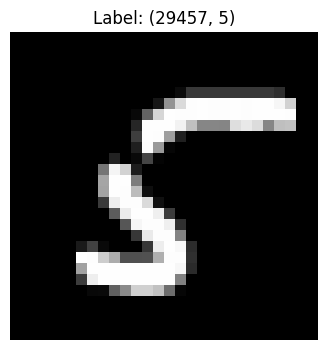

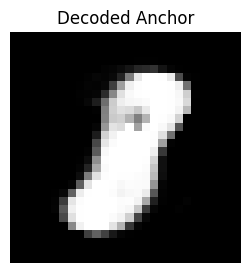

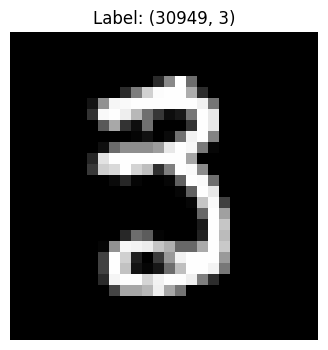

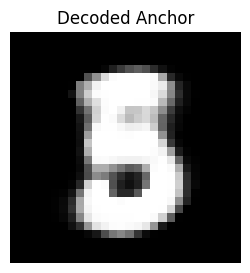

In [19]:
train_loader, test_loader = load_mnist_data()
predefined_anchor_ids = [101, 205]
random_anchor_ids = random.sample(range(len(train_loader.dataset)), 2)
anchors = select_anchors_by_id(AE, embeddings_np, indices, random_anchor_ids, train_loader.dataset, show=True)
relative_coords = compute_relative_coordinates(embeddings_np, anchors, flatten=False)

Plotting

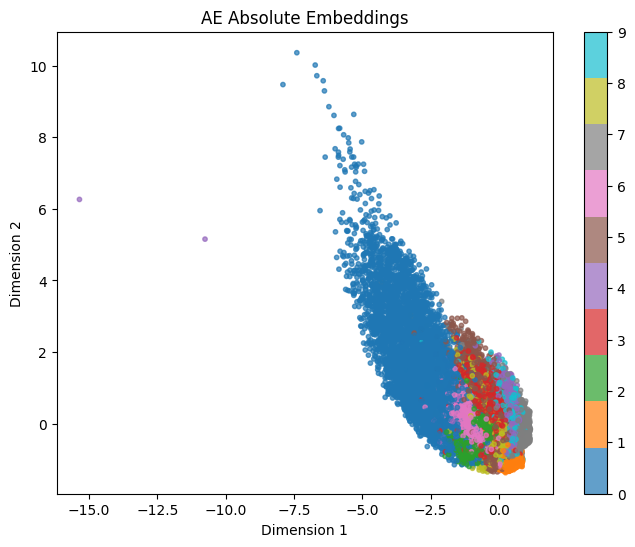

ValueError: 'c' argument has 60000 elements, which is inconsistent with 'x' and 'y' with size 10000.

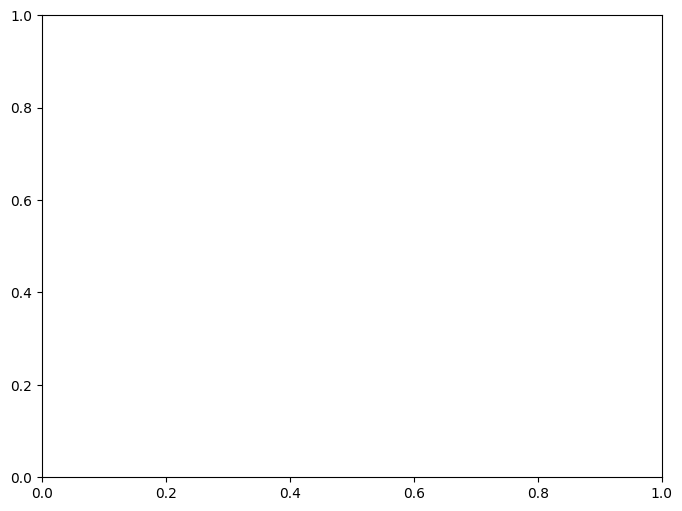

In [247]:
def plot_embeddings(embeddings, labels, title=""):
    """
    Plots the AE latent embeddings (2D) color-coded by label.

    Args:
        embeddings (np.array): Array of shape [N, 2] containing latent embeddings.
        labels (np.array): Array of shape [N] containing the corresponding labels.
    """
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1],
                          c=labels, cmap='tab10', s=10, alpha=0.7)
    plt.colorbar(scatter, ticks=range(10))
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title(title)
    plt.show()


def plot_rel_reps(relative_coords, labels, title=""):
    """
    Plots the relative representations (computed via cosine-similarities to anchors)
    in a 2D space, color-coded by label.

    Args:
        relative_coords (np.array): Array of shape [N, 2] containing relative representations.
        labels (np.array): Array of shape [N] containing the corresponding labels.
    """
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(relative_coords[:, 0], relative_coords[:, 1],
                          c=labels, cmap='tab10', s=10, alpha=0.7)
    plt.colorbar(scatter, ticks=range(10))
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title(title)
    plt.show()

plot_embeddings(embeddings_np, labels_np, title="AE Absolute Embeddings")
plot_rel_reps(relative_coords, labels_np, title="Relative Embeddings")